# Predicting sale price of Bulldozers in future with machine learning

In this notebook, we're going to build a machine learning model, which is able to predict a sale price of a bulldozer based on its previous prices.

## 1. Problem definition

> How well can we predict a bulldozer price in future, based on our previous sold's data (bulldozers data have sold)?

## 2. Data

The data is downloaded from Kaggle: https://www.kaggle.com/c/bluebook-for-bulldozers/data

We have 3 base dataset:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the `RMSLE` (root mean squared log error) between the actual and predicted auction prices.

For more information: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

**Note:** The goal of most regression evaluation metrics is to minimise the error. For example, our goal for this project will be building a model which minimise RMSLE.

## 4. Features

All of features have described in data dictionary that provided by Kaggle:
https://docs.google.com/spreadsheets/d/1zM62fC9pCteimqcUvGzAoJfo50MDrszD9vyyXta2nYg/edit?usp=sharing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
# Import train and valid data set
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory = False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
# Check for missing values
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

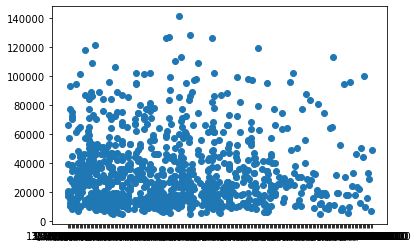

In [5]:
# plot first 1000 example
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

In [6]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

<AxesSubplot:ylabel='Frequency'>

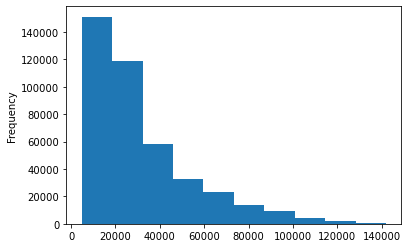

In [7]:
df.SalePrice.plot.hist()

# Parsing dates

When we work with time series data, we wnt to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has ates in it using the `parse_dates` parameter.

In [8]:
# check saledate dtype
df.saledate.dtype

dtype('O')

In [9]:
# Import the data again but this time parse dates
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory = False,
                 parse_dates=["saledate"])

In [10]:
# check saledate dtype again
df.saledate.dtype

dtype('<M8[ns]')

In [11]:
# check saledate column
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

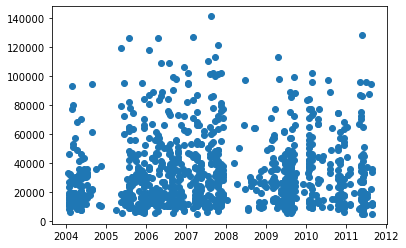

In [12]:
# plot again
fig, ax = plt.subplots()
ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000])

In [13]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [14]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

In [15]:
# Sort DataFrame in order
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

## Make a copy from our original DataFrame

We make a copy from our original data, so when we manipulate our data we've still had our original data.

In [16]:
# make a copy from our DataFrame
df_tmp = df.copy()

In [17]:
df.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


### Add datetime parameters for `saledate` column

We're going to split saledate to saleYear, saleMonth, saleDay, dayOfWeek and dayOfYear with `dt` function.

In [18]:
df_tmp[:1].saledate.dt.year

205615    1989
Name: saledate, dtype: int64

In [19]:
df_tmp[:1].saledate.dt.day

205615    17
Name: saledate, dtype: int64

In [20]:
df_tmp[:1].saledate

205615   1989-01-17
Name: saledate, dtype: datetime64[ns]

In [21]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["dayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["dayOfYear"] = df_tmp.saledate.dt.dayofyear

In [22]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [23]:
# Now we've enriched our datetime, we can remove our saledate column
df_tmp.drop('saledate', axis = 1, inplace = True)

In [24]:
# Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

Now we've done enough EDA. we can go for modeling

## 5.Modelling
We're going to use features to predict SalePrice so X is going to be all columns instead of SalePrice and the SalePrice column would be the y.

In [25]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,dayOfWeek,dayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [26]:
# import our regression model based on sklearn map
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs= -1,
                              random_state= 42)

# fitting model
model.fit(df_tmp.drop('SalePrice', axis= 1),
          df_tmp['SalePrice'])

ValueError: could not convert string to float: 'Low'

We got value here because all of the values is not numeric and also we have lots of missing values. So we should first fix these.

## Convert strings to categories

One of the way to converting data into numeric values (numbers) is that to use pandas categories.

It's working like that turns data to categories which are accessible by their numbers.

Check different datatypes of pandas in: https://pandas.pydata.org/pandas-docs/stable/reference/general_utility_functions.html

In [27]:
# checking one column dtypes as string
pd.api.types.is_string_dtype(df_tmp["state"])

True

In [28]:
# Find the columns that contains string values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


**A sample for .items() function**

In [29]:
# df.items() -> usage
random_dict = {"key1": "hello",
               "key2": "world"}
for key, val in random_dict.items():
    print(f"this is key: {key}",
          f"this is value: {val}")

this is key: key1 this is value: hello
this is key: key2 this is value: world


In [30]:
# Turn all of string values into categorical values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [31]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [32]:
# Check State column categories
df_tmp.state.cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [33]:
# Check State column category's code
df_tmp.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Now we've turned all of our data into numeric values. But there are still lots of missing values.

Before we go for fixiing them, we want to save our DataFrame into .csv.

In [34]:
# Check missing data by percent
df_tmp.isna().sum()/len(df_tmp)

SalesID                     0.000000
SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.048791
YearMade                    0.000000
MachineHoursCurrentMeter    0.642586
UsageBand                   0.821492
fiModelDesc                 0.000000
fiBaseModel                 0.000000
fiSecondaryDesc             0.340993
fiModelSeries               0.857845
fiModelDescriptor           0.818715
ProductSize                 0.524851
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.740520
Enclosure                   0.000809
Forks                       0.520921
Pad_Type                    0.803498
Ride_Control                0.629928
Stick                       0.803498
Transmission                0.544444
Turbocharged                0.803498
B

## Save preprocessed data

In [35]:
# save
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp.csv",
              index=False)

In [36]:
# Import saved DataFrame
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv",
                     low_memory=False)
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18,99,99,99,99
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


## Fill missing value

### Fill missing numerical values

In [37]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

In [38]:
# Check columns with missing values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
dayOfWeek
dayOfYear


In [39]:
# Check which numeric columns have null values
for label,content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [40]:
# Fill numeric missing value with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missed or not
            df_tmp[label + '_is_missing'] = pd.isnull(content)
            # Fill missing value with median
            df_tmp[label] = content.fillna(content.median())

In [41]:
# Difference of median and mean, (median is more robust than mean)
hundreds = np.full((1000), 100)
hundreds_billion = np.append(hundreds, 100000000)
np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.median(hundreds_billion)

(100.0, 100000.0, 100.0, 100.0)

In [42]:
hundreds

array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 10

In [43]:
# Check if there is still any null numeric value
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [44]:
# Check to see how many examples were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

## Fill and Turn missing categorical values into numbers

In [45]:
# Check categorical columns
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [46]:
# Check categorical codes of state column
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [47]:
# Turn categorical variables into numbers and fill their missing values
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add a binary column to indicate whether or not it has missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # turn and fill missing values
        df_tmp[label] = pd.Categorical(content).codes+1

In [48]:
df_tmp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500,14000,50000,16000,22000
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [49]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [50]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now our data is ready. Let's build machine learning model.

In [51]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [52]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)
# fit the model
model.fit(df_tmp.drop("SalePrice", axis=1),
          df_tmp["SalePrice"])

CPU times: user 21min 48s, sys: 8.17 s, total: 21min 56s
Wall time: 6min 15s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [53]:
# score the model with same data
model.score(df_tmp.drop("SalePrice", axis=1),
            df_tmp["SalePrice"])

0.9875468079970562

**Question** Why doesn't the above metric hold water? (why isn't the metric reliable)

> Because we train and test our model with same data.

## Split data into test/valid sets

According to information that provided by Kaggle, train date is about the samples with the `saleYear` until 2011, and valid data is related to samples which were in 2012.

So we should split our data into:

* Train: first < 2012

* Valid: == 2012

In [54]:
df_tmp.saleYear

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [55]:
# check saleYear value counts
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [56]:
# Split data into train and validation
df_val = df_tmp[df_tmp["saleYear"] == 2012]
df_train = df_tmp[df_tmp["saleYear"] != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [57]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]

X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

# Check shapes
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

## Building an evaluation function

In [58]:
# Create an evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculate root mean squared log error between pridictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create a function to evaluate model on different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    valid_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, valid_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, valid_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, valid_preds)}
    return scores

## Testing our model on a subset (to tune hyperparameters)

In [59]:
# # This will take too long for experiment
# %%time
# # instantiate model
# model = RandomForestRegressor(n_jobs=-1,
#                               random_state=42)

# # fit model
# model.fit(X_train, y_train)

Because our data length is too long it will take too much time. So we should experiment our model in parts of our data.

In [60]:
# # Way 1:
# %%time

# model = RandomForestRegressor(n_jobs=-1,
#                               random_state=42)

# model.fit(X_train[:10000], y_train[:10000])

# # But this way is not really good.

This is a better way to makes our experiment faster.

In [61]:
# Instantiate model
model = RandomForestRegressor(n_jobs= -1,
                              random_state=42,
                              max_samples=10000)

In [62]:
%%time

model.fit(X_train, y_train)

CPU times: user 42.9 s, sys: 922 ms, total: 43.8 s
Wall time: 17.4 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [63]:
# Score our model
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

## Tuning Hyperparameters with RandomizedSearchCV

In [64]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Create a dictionary of different hyperparameters with different values
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_samples": [10000],
           "max_features": [0.5, 1, "sqrt", "auto"]}

# Instantiate RandomizedSearchedCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              cv=5,
                              n_iter=2,
                              verbose=True)
# Fitting our rs model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.1min finished


CPU times: user 34.8 s, sys: 4.62 s, total: 39.5 s
Wall time: 1min 13s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [65]:
# Find best params
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 14,
 'min_samples_leaf': 19,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [66]:
# Evaluate our tuned model
show_scores(rs_model)

{'Training MAE': 6562.10770817405,
 'Valid MAE': 8155.8312366903365,
 'Training RMSLE': 0.29335655009478073,
 'Valid RMSLE': 0.3229240880905567,
 'Training R^2': 0.8058248050038916,
 'Valid R^2': 0.7748078969207088}

## Train model with best hyperparameters

**Note:** These hyperparameters found by Daniel by training our model on over 100 iterations of RandomizedSearchCV.

In [67]:
%%time

# idael_params
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42) # we use random state because we want to our result is be reproducable.

# fit our ideal model
ideal_model.fit(X_train, y_train)

CPU times: user 3min 49s, sys: 739 ms, total: 3min 49s
Wall time: 1min 1s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [68]:
# Scores of our ideal model on all of our data
show_scores(ideal_model)

{'Training MAE': 2953.8161137163484,
 'Valid MAE': 5951.247761444453,
 'Training RMSLE': 0.14469006962371855,
 'Valid RMSLE': 0.24524163989538328,
 'Training R^2': 0.9588145522577225,
 'Valid R^2': 0.8818019502450094}

In [69]:
# Scores of our rs model on our 10000 samples of our model
show_scores(rs_model)

{'Training MAE': 6562.10770817405,
 'Valid MAE': 8155.8312366903365,
 'Training RMSLE': 0.29335655009478073,
 'Valid RMSLE': 0.3229240880905567,
 'Training R^2': 0.8058248050038916,
 'Valid R^2': 0.7748078969207088}

## Make prediction on our test data

In [70]:
# Import test DataFrame
df_test = pd.read_csv("./data/bluebook-for-bulldozers/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [71]:
test_preds = ideal_model.predict(df_test)

ValueError: could not convert string to float: 'Low'

We got an error because our test set is not as same format as our data set which our model was trained by. Also there are lots of missing values.

In [ ]:
df_test.info()

In [ ]:
X_train.shape

In [ ]:
df_test.isna().sum()

## Preprocess our test data (get our test dataset in same format as our train dataset)

In [72]:
def preprocess_data(df):
    """
    Transform DataFrame, and return transformed DataFrame.
    """
    # split dates
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["dayOfWeek"] = df.saledate.dt.dayofweek
    df["dayOfYear"] = df.saledate.dt.dayofyear
    
    # drop saledate column
    df.drop("saledate", axis=1, inplace=True)
    
    # loop through columns to fill missing values for numeric columns
    for label, content in df.items():
        # chack if content is numeric
        if pd.api.types.is_numeric_dtype(content):
            # Check if it's null
            if pd.isnull(content).sum():
                # make a column to show that whether it was null or not.
                df[label+"_is_missing"] = pd.isnull(content)
                # fill missing values with median
                df[label] = content.fillna(content.median())
                
    # turn non-numeric columns to categorical columns and fill their missing values
    for label, content in df.items():
        # check whether is numeric or not.
        if not pd.api.types.is_numeric_dtype(content):
            # create a column to show that whether or not it was missed
            df[label+"_is_missing"] = pd.isnull(content)
            # fill missing values
            # add +1 because the missing values codes are -1, and it will change to 0.
            df[label] = pd.Categorical(content).codes+1
            
    return df

In [73]:
# Preprocess test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [74]:
# Make predictions on updated test data
test_preds = ideal_model.predict(df_test)

ValueError: Number of features of the model must match the input. Model n_features is 102 and input n_features is 101 

We got an error because our test data has 101 column, however our train data which our model trained by has 102 columns. So we have to find out the differneces between them.

In [75]:
X_train.shape

(401125, 102)

In [76]:
# find out differences between train data and test data
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

This column doesn't exist in our test data mainly because it hasn't any missing value. So we have to add `auctioneerId_is_missing` manually to our test data.

In [77]:
# adjust df_test manually
df_test["auctioneerID_is_missing"] = False

In [78]:
df_test.head()
# now it has 102 column and we can make prediction on it.

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [79]:
# Make predictin on our test data
test_preds = ideal_model.predict(df_test)

In [80]:
test_preds

array([20614.36780887, 19897.80170658, 44852.21959446, ...,
       14296.98620472, 22164.85757662, 31683.80063427])

We've made some prediction but they are not in same format as Kaggle asked.

https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [81]:
# Reformat test_preds as same as Kaggle asked
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,20614.367809
1,1227844,19897.801707
2,1227847,44852.219594
3,1227848,68346.325323
4,1227863,39487.349708
...,...,...
12452,6643171,46466.092910
12453,6643173,17500.493352
12454,6643184,14296.986205
12455,6643186,22164.857577


In [82]:
# Export prediction data
df_preds.to_csv("./data/bluebook-for-bulldozers/test_predictions.csv", index=False)

## Feature Importance

Feature importance seek to figure out most important features the helps us to find out **target variables** (SalePrice).

Also we can improve and tuned our model based on most important features to have more efficient model.

In [84]:
# find out most important features
ideal_model.feature_importances_

array([3.39445533e-02, 1.81148281e-02, 4.09167072e-02, 1.70752171e-03,
       3.40797459e-03, 2.08200698e-01, 2.95067052e-03, 1.10113725e-03,
       4.16122668e-02, 4.71911805e-02, 6.23815431e-02, 4.67433955e-03,
       1.52524442e-02, 1.52517337e-01, 4.72224713e-02, 5.96817956e-03,
       1.29351899e-03, 2.78088439e-03, 2.37248769e-03, 6.17114453e-02,
       8.13525488e-04, 3.61873268e-05, 9.19098115e-04, 2.23170993e-04,
       1.28102678e-03, 2.06519636e-05, 2.01477316e-03, 6.63364759e-03,
       2.15274492e-03, 2.50178165e-03, 4.63902393e-03, 3.85873985e-03,
       2.76062667e-03, 1.00782454e-03, 2.47969268e-04, 6.04239818e-03,
       7.64997072e-04, 1.57100537e-02, 2.29716203e-03, 2.58372272e-03,
       8.07637426e-04, 9.18548690e-04, 1.35656446e-03, 5.81458569e-04,
       4.96716928e-04, 3.79552257e-04, 5.31712788e-04, 2.71823509e-03,
       8.34294376e-04, 3.12136841e-04, 2.14075157e-04, 7.42422919e-02,
       3.80158492e-03, 5.67641024e-03, 2.87154703e-03, 9.83349904e-03,
      

In [85]:
# check feature importance lenght
len(ideal_model.feature_importances_), len(X_train.columns)

(102, 102)

As we can see the lenght of feature importance is same as the columns of our train sets (lenght of attributes).

In [110]:
# Create a function for plotting feature importance
def plot_features(columns, importances, n=20):
    """
    Visualising feature importance with a horizental bar plot.
    """
    # create DataFrame of features and their importances level
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot feature importance
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set(ylabel="Features", xlabel="Feature_Importance")
    ax.invert_yaxis()

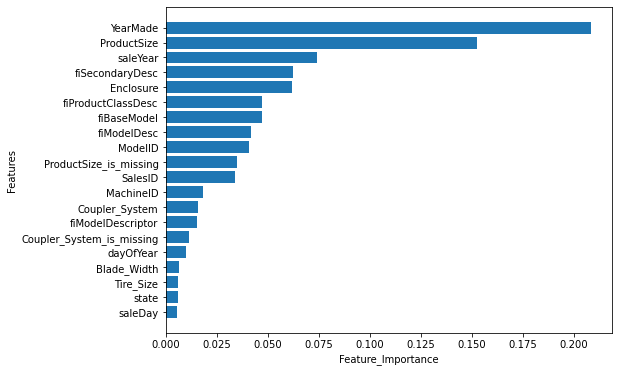

In [111]:
plot_features(X_train.columns, ideal_model.feature_importances_);

Now we can see which attributes have more effect on result of our predictions. So then we can check their definitions.

In [113]:
df["YearMade"].value_counts()

1000    39391
2005    22096
1998    21751
2004    20914
1999    19274
        ...  
1947        1
1942        1
1937        1
2012        1
2013        1
Name: YearMade, Length: 73, dtype: int64

In [114]:
df["ProductSize"].value_counts()

Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: ProductSize, dtype: int64

**Note**

We can search for another models and try to solve our problem by them.

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Also XGBoost and CatBoost can be useful.